# House Price Estimation

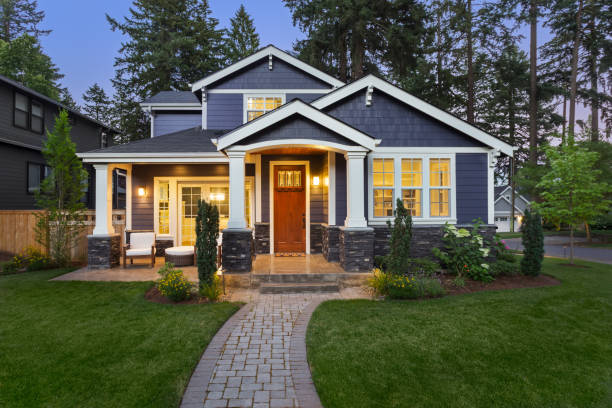

In [1]:
from IPython.display import Image
Image(filename='house.jpg',width=600, height=400)

In [2]:
#importing libraries


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#importing datasets


trainset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")

In [4]:
trainset.shape

(1460, 81)

In [5]:
testset.shape

(1459, 80)

### Data Preprocessing

In [6]:
train_id = trainset.Id
test_id = testset.Id
train_salesprice = trainset.SalePrice

trainset.drop("Id", axis=1, inplace=True)
testset.drop("Id", axis=1, inplace=True)

Text(0.5, 1.0, 'SalePrice distribution')

<Figure size 864x576 with 0 Axes>

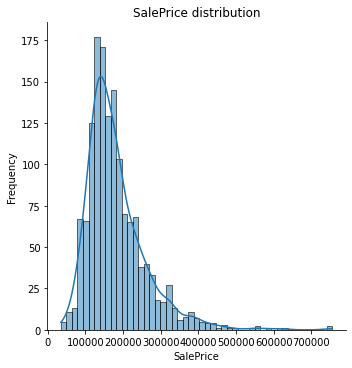

In [7]:
#Let us have a loop at the distribution of the sale pricces of the houses to get a general idea
#of the ranging

plt.figure(figsize=(12,8))
sns.displot(trainset['SalePrice'], kde=True)

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [8]:
#Since we need to Preprocess both the datasets, we will first concatenate them.


data = pd.concat([trainset.drop(['SalePrice'], axis=1), testset])
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [9]:
#Let us now check for all the null values in our dataset

all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071
GarageCond,5.447071


In [10]:
#Let us look at each of these features carefully and decide whether to drop them of fill
#fill the missing values


#PoolQc has the highest value of none values, which is obvious due 
#to the absense of pools in majority of the houses
#Would it make sense to drop this column, maybe but we could also replace null values with a "None"
#type quality to continue with our analysis

data.PoolQC = data.PoolQC.fillna("None")

#MiscFeature shows the miscellaneous features that are not covered in other categories.
#While some houses have a few features, it would not be safe to delete the whole column, instead we can replace
#the null values with a "None"

data.MiscFeature = data.MiscFeature.fillna("None")

#As mentioned in the description, In the alley feature nan values means no access to alleys
#We can simply replace the null values by "None"

data.Alley = data.Alley.fillna("None")

#As mentioned in the description, NA mean no fence. So we will replace this value by "None" as well

data.Fence = data.Fence.fillna("None")

#As mentioned in the description, NA mean no fireplace. So we will replace this value by "None" as well

data.FireplaceQu = data.FireplaceQu.fillna("None")

#Lot frontage means the linear feet of street connected to the properties. Since not many values are missing 
#we can group the neighbourhoods and fill in the median of lotfrontage in those neighbours. If we look at the
#neighbourhood column we can see that all the areas are mentioned within the ames city limits

data.LotFrontage = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#In the garage section, we observe from the deescription that many houses do not have a garage
#Let us handle the qualitative and quantitaive variables accordingly

#We will fill the categorical values with "None" and numerical columns with 0.
for column in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[column] = data[column].fillna('None')
    
for column in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[column] = data[column].fillna(0)
    
#We will do the same for all the basement features since many houses do not have the features of a basement
for column in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[column] = data[column].fillna(0)
    
for column in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[column] = data[column].fillna('None')

#For the Masonry veneer type many houses do not have this feature, as mentioned in the description we will
#replace the null values by "None" and fill the numerical area  by 0.

data.MasVnrType = data.MasVnrType.fillna("None")
data.MasVnrArea = data.MasVnrArea.fillna(0)

#We will fill MSZoning with the most repeating value
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

#As given in the description, we can assume typical unless any deductionsa re warranted. So we will fill
#the null values with "Typ" value
data["Functional"] = data["Functional"].fillna("Typ")

#Since there are no instuctions given for electrical, we will use the mode of the data
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

#Since there are no instuctions given for Kitchen Quality, we will use the mode of the data
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])

#Since there are no instuctions given for Exterior1st and Exterior2nd, we will use the mode of the data
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

#Since there are no instuctions given for Sale Type, we will use the mode of the data
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

#Since there are no instuctions given for Kitchen Quality, we will use the mode of the data
data['MSSubClass'] = data['MSSubClass'].fillna("None")

#Since most of the utilities are all public utilities we will drop this column
data = data.drop(['Utilities'], axis=1)

In [11]:
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


In [12]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,...,0,0,None,None,None,0,12,2008,WD,Normal


### Feature Engineering

In [13]:
#Now since we have handled all our missing values we will move on to Label Encoding our Categorical data

from sklearn.preprocessing import LabelEncoder

#Storing our categorical columns
categorical_columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')


#Process columns, apply LabelEncoder to categorical features
for column in categorical_columns:
    lbl = LabelEncoder() 
    lbl.fit(list(data[column].values)) 
    data[column] = lbl.transform(list(data[column].values))

# shape of our dataset
print('Shape all_data: {}'.format(data.shape))

Shape all_data: (2919, 78)


In [14]:
#Since the area of a house, is most important in determining the house price, let us make a column labelled 
#"Total_Area" and store the total area of the house

data['Total_Area'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [15]:
#We can also add up all the bathrooms to give us the total number of bathrooms

data['Total_Bathrooms'] = data['BsmtFullBath']+data['BsmtHalfBath']*0.5+data['FullBath']+data['HalfBath']*0.5

In [16]:
#There are many numerical variables, which are actually categorical
#To handle this anomally we will convert these numerical data to strings

#MSSubClass=The building class
data['MSSubClass'] = data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
data['OverallCond'] = data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [17]:
data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Total_Area,Total_Bathrooms
0,5,RL,65.0,8450,1,1,3,Lvl,Inside,0,...,3,4,None,0,1,2,WD,Normal,2566.0,3.5
1,0,RL,80.0,9600,1,1,3,Lvl,FR2,0,...,3,4,None,0,4,1,WD,Normal,2524.0,2.5
2,5,RL,68.0,11250,1,1,0,Lvl,Inside,0,...,3,4,None,0,8,2,WD,Normal,2706.0,3.5
3,6,RL,60.0,9550,1,1,0,Lvl,Corner,0,...,3,4,None,0,1,0,WD,Abnorml,2473.0,2.0
4,5,RL,84.0,14260,1,1,0,Lvl,FR2,0,...,3,4,None,0,11,2,WD,Normal,3343.0,3.5
5,4,RL,85.0,14115,1,1,0,Lvl,Inside,0,...,3,2,Shed,700,9,3,WD,Normal,2158.0,2.5
6,0,RL,75.0,10084,1,1,3,Lvl,Inside,0,...,3,4,None,0,7,1,WD,Normal,3380.0,3.0
7,5,RL,80.0,10382,1,1,0,Lvl,Corner,0,...,3,4,Shed,350,10,3,WD,Normal,3197.0,3.5
8,4,RM,51.0,6120,1,1,3,Lvl,Inside,0,...,3,4,None,0,3,2,WD,Abnorml,2726.0,2.0
9,15,RL,50.0,7420,1,1,3,Lvl,Corner,0,...,3,4,None,0,0,2,WD,Normal,2068.0,2.0


In [18]:
data.to_csv("preprocessed_data", index=False)

In [19]:
#Getting the dummy variables for our categorical columns

data = pd.get_dummies(data)
print(data.shape)

(2919, 260)


In [20]:
x = data[:1460]
test = data[1460:]
y = train_salesprice

In [21]:
import xgboost as xgb

In [22]:
#Splitting data into training and test sets


from sklearn.model_selection import train_test_split 

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

dep = np.arange(1,9)
weight = np.arange(1,9)

param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [5, 6, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200],
        'objective': ['reg:squarederror']
}

#XGBRegressor classifier
classifiers = XGBRegressor()

clf_cv = GridSearchCV(classifiers, param_grid=param_tuning,cv=6)

clf_cv.fit(x,y)

# Print the tuned parameter and score
print("Tuned XGBoost Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))

In [ ]:
Y_pred = clf_cv.predict(test)

In [ ]:
testset['SalePrice'] = Y_pred
testset['Id'] = test_id
testset[['Id', 'SalePrice']].to_csv('xgb_submission.csv', index=False)